# Table of Contents
 <p><div class="lev1 toc-item"><a href="#General-settings" data-toc-modified-id="General-settings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>General settings</a></div><div class="lev1 toc-item"><a href="#Initial-exploration" data-toc-modified-id="Initial-exploration-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Initial exploration</a></div><div class="lev2 toc-item"><a href="#Preprocess-datetimes,-distance-and-speed" data-toc-modified-id="Preprocess-datetimes,-distance-and-speed-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preprocess datetimes, distance and speed</a></div><div class="lev2 toc-item"><a href="#Anomalies" data-toc-modified-id="Anomalies-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Anomalies</a></div><div class="lev3 toc-item"><a href="#Visual-quantile-analysis" data-toc-modified-id="Visual-quantile-analysis-221"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Visual quantile analysis</a></div><div class="lev2 toc-item"><a href="#General-distributions" data-toc-modified-id="General-distributions-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>General distributions</a></div><div class="lev2 toc-item"><a href="#Duration" data-toc-modified-id="Duration-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Duration</a></div><div class="lev3 toc-item"><a href="#Duration-by-distance" data-toc-modified-id="Duration-by-distance-241"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Duration by distance</a></div><div class="lev2 toc-item"><a href="#Distance" data-toc-modified-id="Distance-25"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Distance</a></div><div class="lev3 toc-item"><a href="#City-mapping" data-toc-modified-id="City-mapping-251"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>City mapping</a></div><div class="lev1 toc-item"><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Feature engineering</a></div><div class="lev1 toc-item"><a href="#Classification" data-toc-modified-id="Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Classification</a></div>

# General settings

In [25]:
import pandas as pd
import numpy as np
from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('notebook')

In [26]:
drop_pos = ['dropoff_longitude','dropoff_latitude']
pick_pos = ['pickup_longitude', 'pickup_latitude']

lon_pos = ['pickup_longitude', 'dropoff_longitude']
lat_pos = ['pickup_latitude', 'dropoff_latitude']

position = ['pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude']


week = ['Sunday', 'Monday', 'Tuesday', 'Thursday', 'Friday', 'Saturday']

# Initial exploration

In [27]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [28]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


## Preprocess datetimes, distance and speed

In [31]:
import math
def distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d


In [32]:
def add_date_specifics(df, column_name, new_prefix):
    df.loc[:,column_name] = pd.to_datetime(df[column_name])
    
    df[new_prefix +'year'] = df[column_name].dt.year
    df[new_prefix +'month'] = df[column_name].dt.month
    df[new_prefix +'yearday'] = df[column_name].dt.dayofyear
    df[new_prefix +'hour'] = df[column_name].dt.hour
    df[new_prefix +'minute'] = df[column_name].dt.minute
    df[new_prefix +'weekday'] = df[column_name].dt.weekday_name
    

median_lon = train.pickup_longitude.median()
def add_distance(df):
    """
    Abaixo usamos a aproximação euclideana, ignorando a curvatura da terra,
    por tratarmos de uma unica cidade
    """
    lat_km = 110574
    lon_km = 111320*np.cos(np.pi*median_lon/180)
    conversion = np.array([lon_km, lat_km])
    
    df['line_distance'] = np.sqrt((((df[pick_pos].values - df[drop_pos].values)*conversion)**2).sum(axis=1))
    
def add_speed(df):
    """ Velocidade em km/h"""
    df['speed(km/h)'] = 3600*df['line_distance']/df['trip_duration']
    
    

In [33]:
add_date_specifics(train, 'pickup_datetime', 'pickup_')
add_date_specifics(train, 'dropoff_datetime', 'dropoff_')
add_distance(train)
add_speed(train)

add_date_specifics(test, 'pickup_datetime', 'pickup_')
add_distance(test)

## Anomalies

In [311]:
train['log_trip_duration'] = np.log10(train['trip_duration'])

val_cols = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'log_trip_duration'] 
Q1, Q3 = train[val_cols].quantile(.25), train[val_cols].quantile(.75)
IQR = Q3 - Q1

In [324]:
is_outlier = (train[val_cols] < Q1 - 4*IQR) | (train[val_cols] > Q3 + 4*IQR)

In [325]:
is_outlier.sum()

passenger_count          5
pickup_longitude     50863
pickup_latitude        408
dropoff_longitude    26631
dropoff_latitude      2003
log_trip_duration     3507
dtype: int64

In [326]:
train[is_outlier['log_trip_duration']].sort_values('trip_duration',ascending=False)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_weekday,dropoff_weekday,line_distance,log_trip_duration
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,Saturday,Friday,0.219305,6.547317
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,Tuesday,Sunday,0.014747,6.347840
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,Saturday,Tuesday,0.067746,6.311664
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,Tuesday,Wednesday,0.211471,6.287743
1234291,id1942836,2,2016-02-15 23:18:06,2016-02-16 23:17:58,2,-73.794525,40.644825,-73.991051,40.755573,N,86392,Monday,Tuesday,0.225583,4.936474
295382,id0593332,2,2016-05-31 13:00:39,2016-06-01 13:00:30,1,-73.781952,40.644688,-73.993874,40.745926,N,86391,Tuesday,Wednesday,0.234862,4.936469
73816,id0953667,2,2016-05-06 00:00:10,2016-05-07 00:00:00,1,-73.996010,40.753220,-73.979027,40.740601,N,86390,Friday,Saturday,0.021158,4.936463
59891,id2837671,2,2016-06-30 16:37:52,2016-07-01 16:37:39,1,-73.992279,40.749729,-73.962524,40.800770,N,86387,Thursday,Friday,0.059080,4.936448
1360439,id1358458,2,2016-06-23 16:01:45,2016-06-24 16:01:30,1,-73.782089,40.644806,-73.985016,40.666828,N,86385,Thursday,Friday,0.204118,4.936438
753765,id2589925,2,2016-05-17 22:22:56,2016-05-18 22:22:35,4,-74.006111,40.734680,-73.958809,40.815449,N,86379,Tuesday,Wednesday,0.093601,4.936408


In [309]:
np.log10(train.trip_duration).quantile(.25)
np.log10(train.trip_duration).quantile(.75)

3.031408464251624

In [35]:
train['duration_from_date'] = (train['dropoff_datetime']-train['pickup_datetime']).dt.total_seconds().astype(int)
print('Number of duration inconsistencies:', 
      (train.duration_from_date != train.trip_duration).sum(), 
      '(time provided vs time from datetime diff)')

Number of duration inconsistencies: 0 (time provided vs time from datetime diff)


### Visual quantile analysis

In [11]:
quants = pd.DataFrame()
for p in np.arange(0,1.001,.001):
    quants = quants.append(train[position].quantile(p))

Text(0.5,1,'')

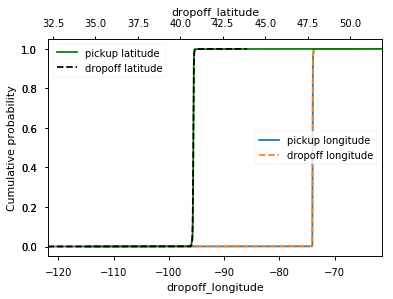

In [12]:
quants[lon_pos].reset_index().set_index(['pickup_longitude'])['index'].plot(label='pickup longitude')
quants[lon_pos].reset_index().set_index(['dropoff_longitude'])['index'].plot(linestyle='--',label='dropoff longitude')
plt.legend(loc='center right')

plt.twiny()
quants[lat_pos].reset_index().set_index(['pickup_latitude'])['index'].plot(color='g',label='pickup latitude')
quants[lat_pos].reset_index().set_index(['dropoff_latitude'])['index'].plot(linestyle='--',color='k', label='dropoff latitude')

plt.ylabel('Cumulative probability')
plt.legend(loc='upper left')
plt.title('')

## General distributions

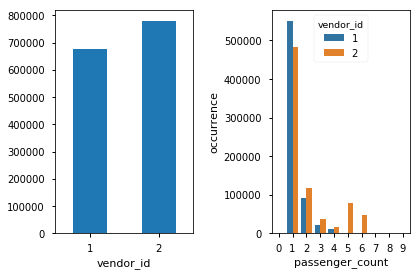

In [86]:
ax=plt.subplot(1,2,1)
train.vendor_id.value_counts()[[1,2]].plot.bar(ax=ax, rot=0); plt.xlabel('vendor_id')

ax=plt.subplot(1,2,2)
passenger_by_cny = train.groupby('vendor_id').apply(lambda df: df.passenger_count.value_counts()).reset_index()
passenger_by_cny = passenger_by_cny.rename(columns={'level_1':'passenger_count', 'passenger_count':'occurrence'})
sns.barplot(x='passenger_count', y='occurrence', hue='vendor_id', data=passenger_by_cny, ax= ax)


plt.tight_layout()

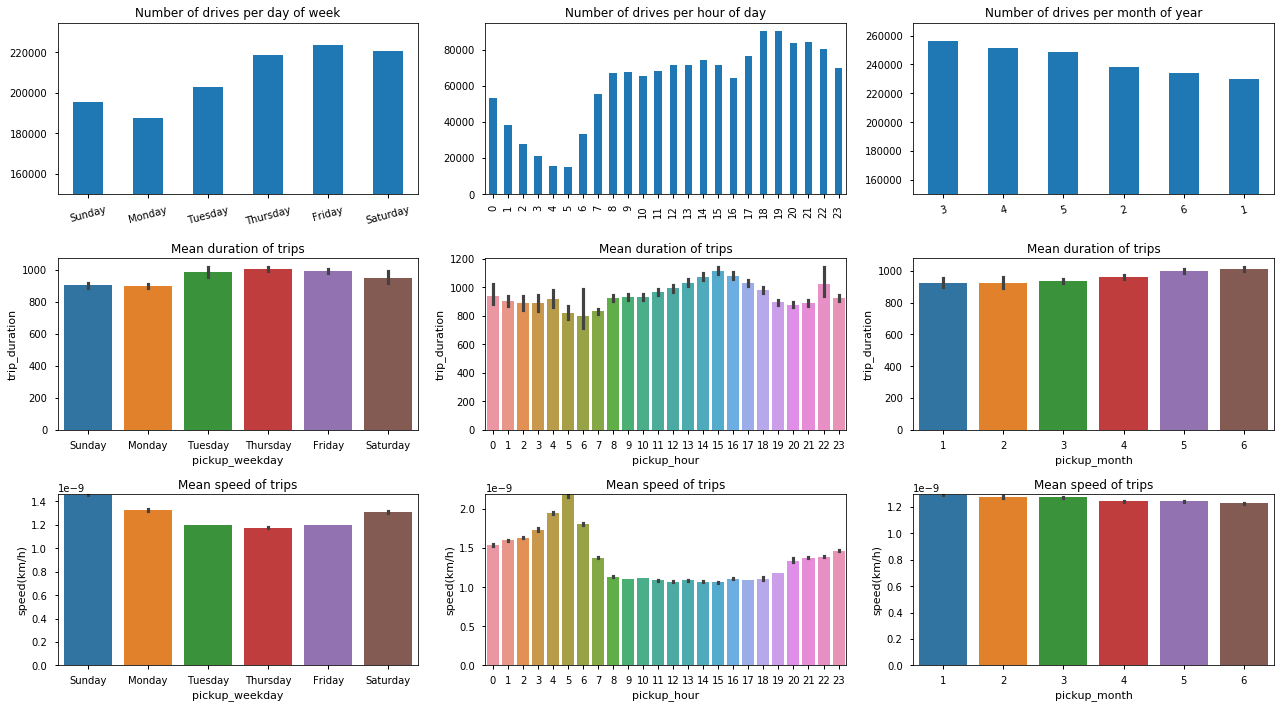

In [183]:
plt.figure(figsize=(18,10))

# Weekday-------------
ax=plt.subplot2grid((3,3),(0,0))
train.pickup_weekday.value_counts()[week].plot.bar(ax=ax, rot=15)
plt.title('Number of drives per day of week'); plt.ylim(150000);

ax=plt.subplot2grid((3,3),(1,0))
sns.barplot(x='pickup_weekday', y='trip_duration', data=train, order=week, ax=ax)
plt.title('Mean duration of trips')

ax=plt.subplot2grid((3,3),(2,0))
sns.barplot(x='pickup_weekday', y='speed(km/h)', data=train, order=week, ax=ax)
plt.title('Mean speed of trips')

# Hour -------------
ax=plt.subplot2grid((3,3),(0,1))
train.pickup_hour.value_counts()[np.arange(24)].plot.bar(ax=ax)
plt.title('Number of drives per hour of day')

ax=plt.subplot2grid((3,3),(1,1))
sns.barplot(x='pickup_hour', y='trip_duration', data=train, ax=ax)
plt.title('Mean duration of trips')

ax=plt.subplot2grid((3,3),(2,1))
sns.barplot(x='pickup_hour', y='speed(km/h)', data=train, ax=ax)
plt.title('Mean speed of trips')

# Month-------------
ax=plt.subplot2grid((3,3),(0,2))
train.pickup_month.value_counts().plot.bar(ax=ax, rot=15); plt.ylim(150000);
plt.title('Number of drives per month of year');

ax = plt.subplot2grid((3,3),(1,2))
sns.barplot(x='pickup_month', y='trip_duration', data=train, ax=ax)
plt.title('Mean duration of trips')

ax=plt.subplot2grid((3,3),(2,2))
sns.barplot(x='pickup_month', y='speed(km/h)', data=train, ax=ax)
plt.title('Mean speed of trips')


plt.tight_layout()

NameError: name 'is_central' is not defined

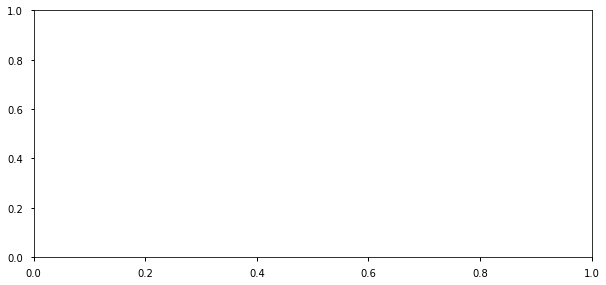

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sns.violinplot(x='pickup_weekday', y= 'Latitude', hue='variable',data=train[is_central][lat_pos+['pickup_weekday']].melt(id_vars='pickup_weekday', value_name='Latitude'));
plt.subplot(2,1,2)
sns.violinplot(x='pickup_weekday', y= 'Longitude', hue='variable',data=train[is_central][lon_pos+['pickup_weekday']].melt(id_vars='pickup_weekday', value_name='Longitude'));

## Duration

In [223]:
mean_duration = lambda df: df.trip_duration.mean()

In [231]:
duration_map = citymap(train, func=mean_duration)

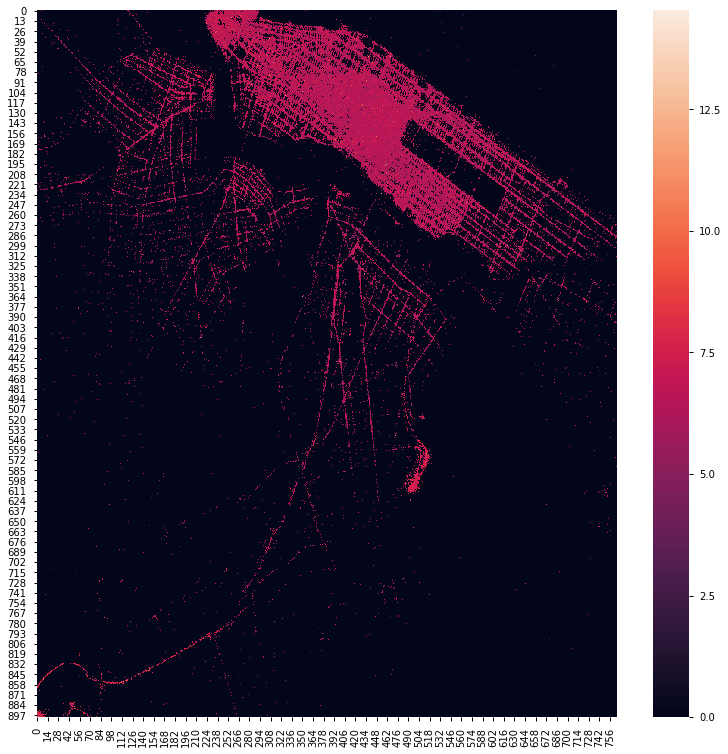

In [236]:
plt.figure(figsize=(13,13))
sns.heatmap(np.log(duration_map+1))

In [1]:
sns.distplot(np.log10(train.trip_duration))

plt.title('Distribuição das durações de viagem')
plt.xlabel('Log_{10}')

NameError: name 'sns' is not defined

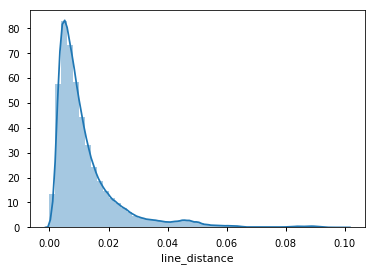

In [271]:
sns.distplot(np.log10(train[is_central].line_distance+1))

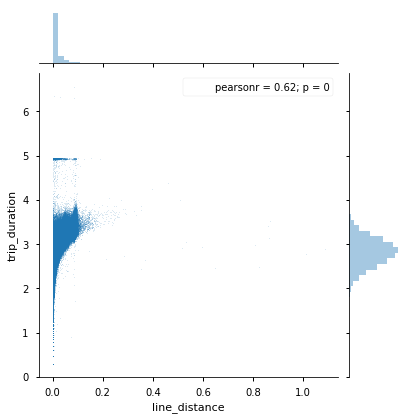

In [258]:
sns.jointplot(x='line_distance', y='trip_duration', data=np.log10(train[['trip_duration', 'line_distance']]+1),s=.02)

KeyboardInterrupt: 

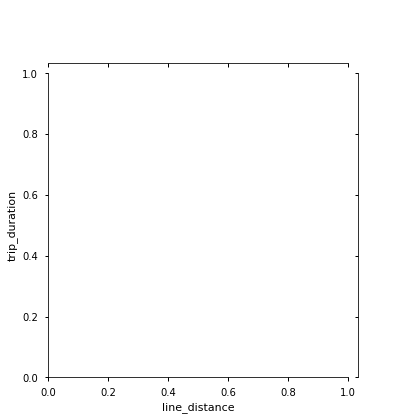

In [259]:
sns.jointplot(x='line_distance', y='trip_duration', data=np.log10(train[['trip_duration', 'line_distance']]+1), kind='kde')

### Duration by distance

## Distance

Because there are locations too far away, we will chop off some of the distribution to be able to look at them better.

In [13]:
is_central = ((train[position] > train[position].quantile(.01)) & (train[position] < train[position].quantile(.99))).sum(axis=1)==4
positions_to_plot = train[is_central]

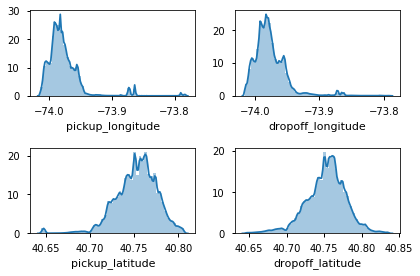

In [14]:
ax = plt.subplot(2,2,1)
sns.distplot(positions_to_plot['pickup_longitude'])
ax = plt.subplot(2,2,2)
sns.distplot(positions_to_plot['dropoff_longitude'])
ax = plt.subplot(2,2,3)
sns.distplot(positions_to_plot['pickup_latitude'])
ax = plt.subplot(2,2,4)
sns.distplot(positions_to_plot['dropoff_latitude'])

plt.tight_layout()

### City mapping

In [15]:
pick_count = train[pick_pos][is_central].apply(np.around, decimals=4).groupby(pick_pos).agg(np.size)
drop_count = train[drop_pos][is_central].apply(np.around, decimals=4).groupby(drop_pos).agg(np.size)

In [ ]:
precision = 4000
lats = np.arange( int(precision*drop_count.reset_index()['dropoff_latitude'].min()),
                  int(precision*drop_count.reset_index()['dropoff_latitude'].max())+1)

lons = np.arange( int(precision*drop_count.reset_index()['dropoff_longitude'].min()),
                  int(precision*drop_count.reset_index()['dropoff_longitude'].max())+1)

#pickmap = np.zeros((lons.shape[0], lats.shape[0]))
#dropmap = np.zeros((lons.shape[0], lats.shape[0]))

In [ ]:
def citymap(df, pos = pick_pos, func=np.size):
    densemap = np.zeros((lons.shape[0], lats.shape[0]))
    local = df.copy()
    local[pos] = local[pos].apply(np.around, decimals=4)
    sparse_vals = local.groupby(pos).apply(func)
    for (lon, lat), count in sparse_vals.iteritems():
        i = int(precision*lon-lons[0])
        j = int(precision*lat-lats[0])
        if i < densemap.shape[0] and j < densemap.shape[1] and i>=0 and j>=0:
            densemap[i,j] = count
    return densemap

In [215]:
# for (lon, lat), count in pick_count.iteritems():
#     i = int(precision*lon-lons[0])
#     j = int(precision*lat-lats[0])
#     if i < pickmap.shape[0] and j < pickmap.shape[1]:
#         pickmap[i,j] = count
pickmap = citymap(train[is_central])        
pick_plot = pd.DataFrame(np.log10(pickmap+1), index = pd.Index(lons/precision, name='Longitude'), columns=pd.Index(lats/precision, name='Latitude'))

# for (lon, lat), count in drop_count.iteritems():
#     i = int(precision*lon-lons[0])
#     j = int(precision*lat-lats[0])
#     dropmap[i,j] = count
    
dropmap = citymap(train[is_central], pos = drop_pos)
drop_plot = pd.DataFrame(np.log10(dropmap+1), index = pd.Index(lons/precision, name='Longitude'), columns=pd.Index(lats/precision, name='Latitude'))

Text(0.5,1,'Drop-offs')

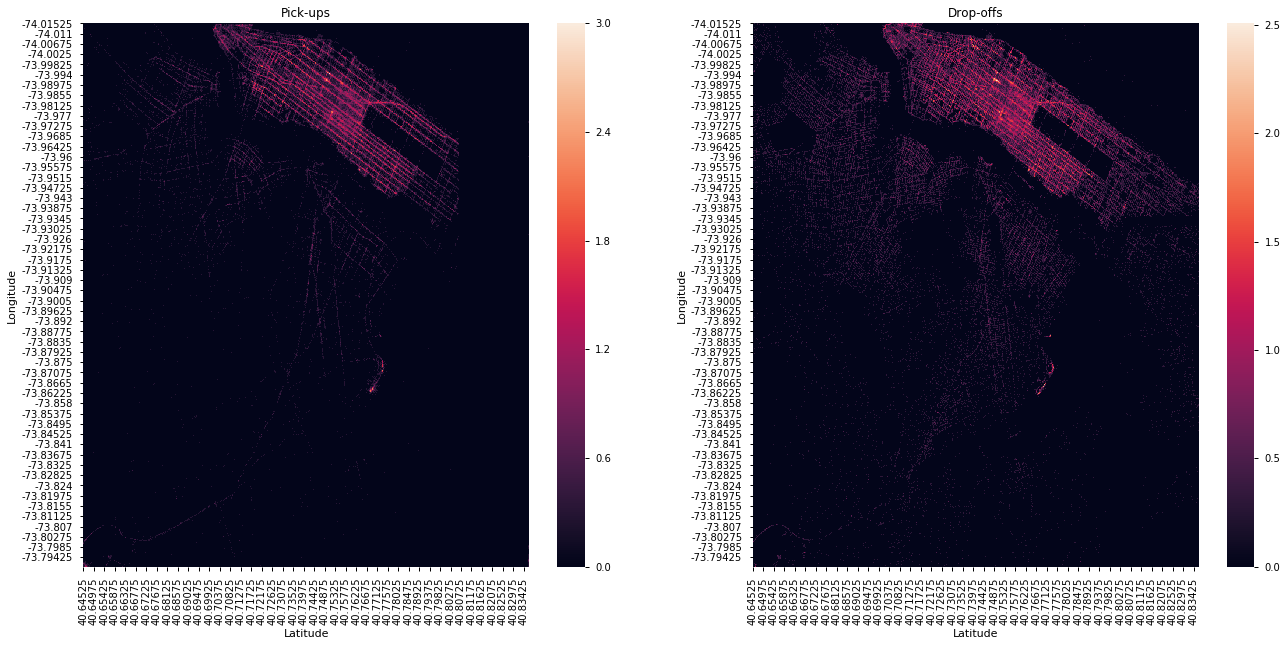

In [216]:
plt.figure(figsize=(22,10))
ax = plt.subplot(1,2,1)
sns.heatmap(pick_plot); plt.title('Pick-ups')
ax = plt.subplot(1,2,2)
sns.heatmap(drop_plot); plt.title('Drop-offs')

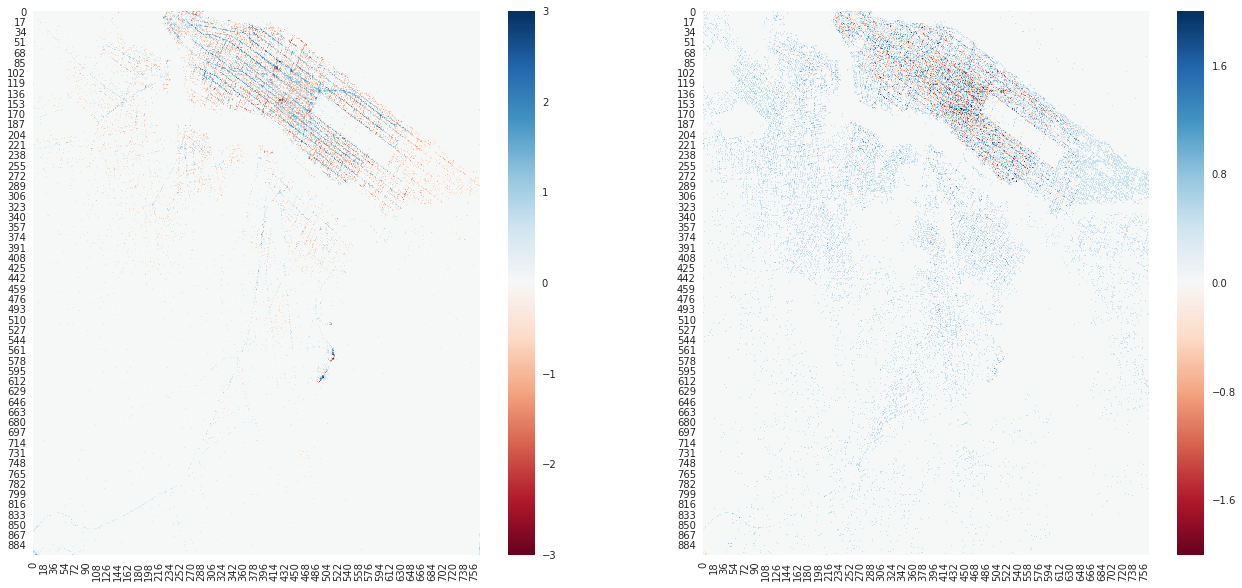

In [538]:
plt.figure(figsize=(22,10))
ax = plt.subplot(1,2,1)
sns.heatmap(np.sign(pickmap - dropmap)* np.log10(abs(pickmap - dropmap+1)), cmap='RdBu', vmin=-3, vmax=3)
ax = plt.subplot(1,2,2)
sns.heatmap(np.sign(pickmap - dropmap)*np.log10(abs(pickmap - dropmap+1)/(dropmap+pickmap+1)), cmap='RdBu', vmin=-2,vmax=2)

# Feature engineering

In [37]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()

In [34]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_minute,pickup_weekday,dropoff_year,dropoff_month,dropoff_yearday,dropoff_hour,dropoff_minute,dropoff_weekday,line_distance,speed(km/h)
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,24,Monday,2016,3,74,17,32,Monday,597.020139,4723.675822
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,43,Sunday,2016,6,164,0,54,Sunday,1007.322706,5469.625552
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,35,Tuesday,2016,1,19,12,10,Tuesday,6009.219662,10185.118070
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,32,Wednesday,2016,4,97,19,39,Wednesday,1466.952278,12310.089044
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,30,Saturday,2016,3,86,13,38,Saturday,1181.908067,9781.308141


In [38]:
train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_year', 'pickup_month', 'pickup_yearday',
       'pickup_hour', 'pickup_minute', 'pickup_weekday', 'dropoff_year',
       'dropoff_month', 'dropoff_yearday', 'dropoff_hour', 'dropoff_minute',
       'dropoff_weekday', 'line_distance', 'speed(km/h)'],
      dtype='object')

In [ ]:
# Hour to cicles

# Hour to one-hot

# Weekday to cycle?

# Weekday to one-hot

# Month to one-hot



# Classification

In [273]:
from xgboost import XGBRegressor
from skopt import gp_minimize